<a href="https://colab.research.google.com/github/maverick98/Coursera/blob/master/mvp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product
from typing import Union

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [23]:
!cp /content/drive/MyDrive/SimplePredict_Additional_Historical_Transformed.csv .
!cp /content/drive/MyDrive/SimplePredict_Primary_Preprocessed.csv .
!cp /content/drive/MyDrive/SimplePredict_Additional_Future_Transformed.csv .

In [320]:
df1=pd.read_csv('SimplePredict_Additional_Historical_Preprocessed.csv')
df2=pd.read_csv('SimplePredict_Primary_Preprocessed.csv')


In [ ]:
df1.info(),df2.info()

In [321]:
df = pd.merge(df1, df2, on=['SeriesId', 'Date'],how='left')

In [198]:
df.columns

Index(['SeriesId', 'Date', 'Volume', 'Cost', 'Target'], dtype='object')

In [ ]:
df.head(100)

In [322]:
from sklearn.preprocessing import StandardScaler
scaler1 = StandardScaler()
scaler_target = StandardScaler()
# Define which columns to scale
columns_to_scale = [ 'Volume', 'Cost']
target_column=[ 'Target']
df_scaled = df.copy()
df_scaled[columns_to_scale] = scaler1.fit_transform(df[columns_to_scale])
df_scaled[target_column] = scaler_target.fit_transform(df[target_column])

df_inversed = df.copy()
df_inversed[columns_to_scale] = scaler1.inverse_transform(df_scaled[columns_to_scale])
df_inversed[target_column] = scaler_target.inverse_transform(df_scaled[target_column])


In [323]:
df=df_scaled
df.head(3)

,SeriesId,Date,Volume,Cost,Target
0,76ceac28-610c-31cf-9255-af5f4154e705,01-01-2024,0.731989,-1.507776,0.208677
1,76ceac28-610c-31cf-9255-af5f4154e705,01-02-2024,0.731989,-1.507776,1.128401
2,76ceac28-610c-31cf-9255-af5f4154e705,01-03-2024,-0.938083,-1.507776,1.723517


In [324]:
df_inversed.head(3)

,SeriesId,Date,Volume,Cost,Target
0,76ceac28-610c-31cf-9255-af5f4154e705,01-01-2024,100.0,10.0,44.0
1,76ceac28-610c-31cf-9255-af5f4154e705,01-02-2024,100.0,10.0,78.0
2,76ceac28-610c-31cf-9255-af5f4154e705,01-03-2024,50.0,10.0,100.0


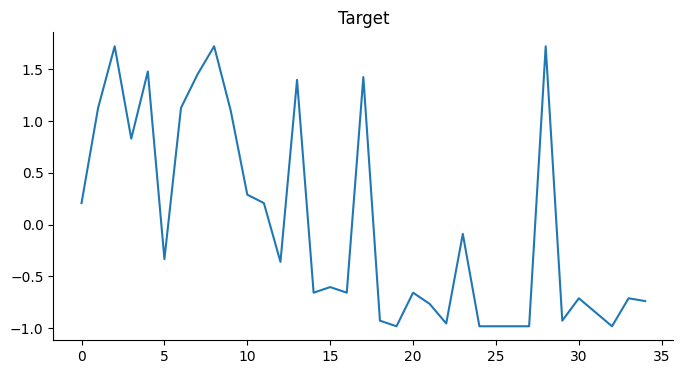

In [205]:
# @title Target

from matplotlib import pyplot as plt
df['Target'].plot(kind='line', figsize=(8, 4), title='Target')
plt.gca().spines[['top', 'right']].set_visible(False)

In [182]:
# Calculate the IQR
Q1 = df['Target'].quantile(0.25)
print('Q1 ={}'.format(Q1))
Q3 = df['Target'].quantile(0.75)
print('Q3 ={}'.format(Q3))
IQR = Q3 - Q1
print('IQR={}'.format(IQR))
# Define the acceptable range based on the IQR
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print('lower_bound ={}'.format(lower_bound))
print('upper_bound ={}'.format(upper_bound))

# Filter out the outliers
df_filtered = df[(df['Target'] >= lower_bound) & (df['Target'] <= 80)]
#df_filtered.head(100)

Q1 =1.75
Q3 =35.75
IQR=34.0
lower_bound =-49.25
upper_bound =86.75


In [ ]:
df.head(100)

In [308]:
train_df=df[:-12][['Volume','Target']]
test_df=df[-12:][['Volume','Target']]


In [ ]:
train_df.head(100)

In [325]:
ADF_result = adfuller(train_df['Target'])

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -3.7299732465524014
p-value: 0.003710771027217242


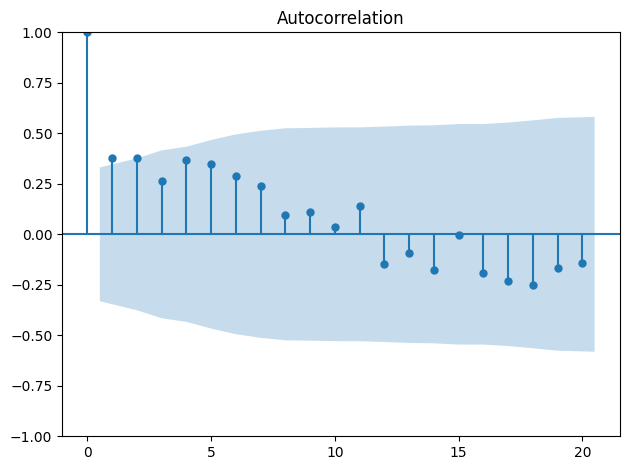

In [326]:
plot_acf(train_df['Target'], lags=20);

plt.tight_layout()

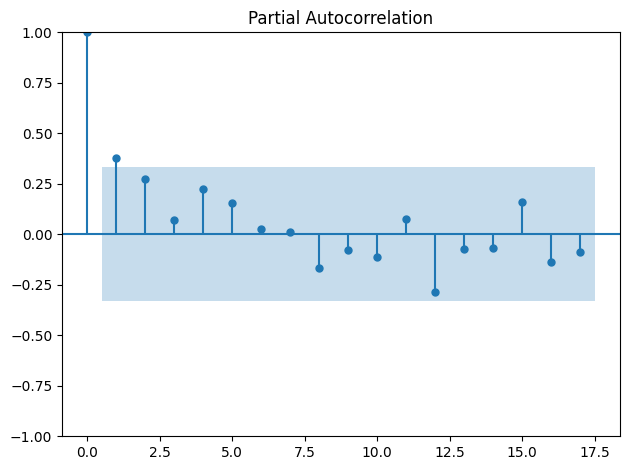

In [327]:
plot_pacf(train_df['Target'], lags=17);

plt.tight_layout()

In [328]:
target = train_df['Target']
exog = train_df[['Volume']]
all_endog=df[:][['Volume','Target']]
all_target=all_endog['Target']
all_exog=df[:][['Volume']]

In [ ]:
all_target[:-12].head(100)

In [213]:
len(target),len(exog),len(all_endog),len(all_exog)

(35, 35, 47, 47)

In [329]:
def optimize_SARIMAX(endog: Union[pd.Series, list], exog: Union[pd.Series, list], order_list: list, d: int) -> pd.DataFrame:

    results = []

    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(
                endog,
                exog,
                order=(order[0], d, order[1]),

                simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order,d, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)','d', 'AIC']

    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

In [330]:
p = range(0, 10, 1)
d = 0
q = range(0, 10, 1)


parameters = product(p, q)
parameters_list = list(parameters)


In [331]:
target_train = target
exog_train = exog

result_df = optimize_SARIMAX(target_train, exog_train, parameters_list, d)
result_df

  0%|          | 0/100 [00:00<?, ?it/s]

,"(p,q)",d,AIC
0,"(1, 1)",0,350.118980
1,"(4, 3)",0,350.890006
2,"(4, 4)",0,351.071392
3,"(5, 2)",0,351.115163
4,"(3, 5)",0,351.596117
...,...,...,...
95,"(9, 8)",0,377.840889
96,"(8, 8)",0,380.418770
97,"(7, 7)",0,384.037401
98,"(6, 8)",0,385.603566


In [332]:
best_model = SARIMAX(target_train, exog_train, order=(1,0,1), simple_differencing=False)
best_model_fit = best_model.fit(disp=False)

print(best_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                 Target   No. Observations:                   35
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -171.059
Date:                Thu, 25 Apr 2024   AIC                            350.119
Time:                        13:23:32   BIC                            356.340
Sample:                             0   HQIC                           352.267
                                 - 35                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Volume         0.1606      0.167      0.961      0.337      -0.167       0.488
ar.L1          0.9721      0.037     26.311      0.000       0.900       1.045
ma.L1         -0.7282      0.152     -4.805      0.0

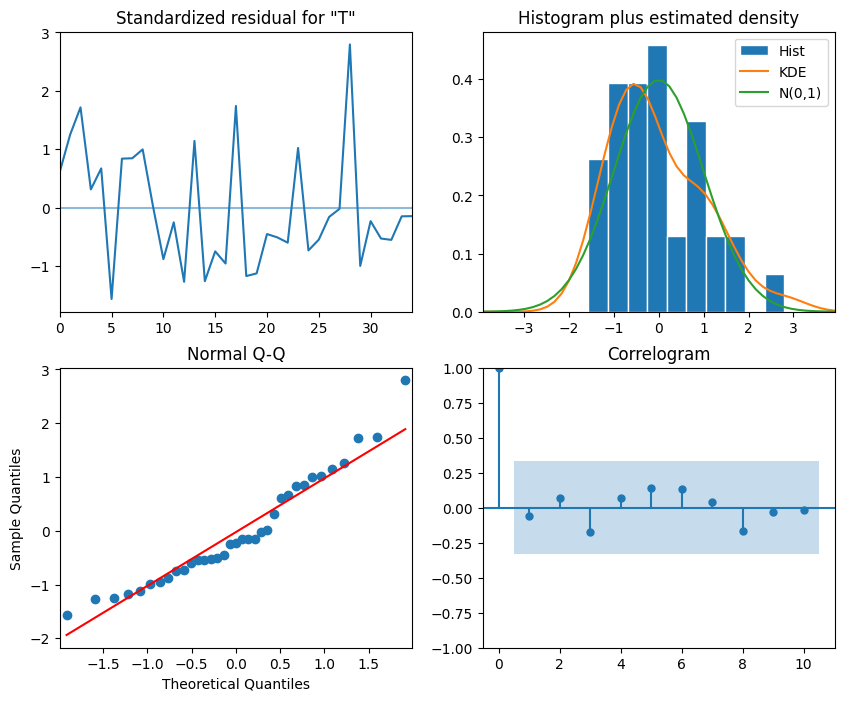

In [333]:
best_model_fit.plot_diagnostics(figsize=(10,8));

In [334]:
def recursive_forecast(endog: Union[pd.Series, list], exog: Union[pd.Series, list], train_len: int, horizon: int, window: int) -> list:

    total_len = train_len + horizon
    pred_SARIMAX = []

    for i in range(train_len, total_len, window):
        model = SARIMAX(endog[:i], exog[:i], order=(1,0,1), simple_differencing=False)
        res = model.fit(disp=False)
        predictions = res.get_prediction(exog=exog)
        oos_pred = predictions.predicted_mean.iloc[-window:]
        pred_SARIMAX.extend(oos_pred)

    return pred_SARIMAX

In [335]:
target_train = all_target[:35]
target_test = all_target[35:]

pred_df = pd.DataFrame({'actual': target_test})

TRAIN_LEN = len(target_train)

HORIZON = len(target_test)
WINDOW = 1
print('TRAIN_LEN {}'.format(TRAIN_LEN))
print('HORIZON {}'.format(HORIZON))


pred_SARIMAX = recursive_forecast(all_target, all_exog, TRAIN_LEN, HORIZON, WINDOW)


pred_df['Target'] = pred_SARIMAX

pred_df

TRAIN_LEN 35
HORIZON 12


,actual,Target
35,NaN,-0.504673
36,NaN,-0.771367
37,NaN,-0.488536
38,NaN,-0.455486
39,NaN,-0.562019
40,NaN,-0.587866
41,NaN,-0.367807
42,NaN,-0.342028
43,NaN,-0.455392
44,NaN,-0.322551


In [336]:
pred_SARIMAX

[-0.5046727069004169,
 -0.771366706272427,
 -0.48853551420357855,
 -0.4554863490243068,
 -0.5620186230484657,
 -0.5878663509610528,
 -0.36780730235418374,
 -0.3420279344190205,
 -0.4553922459812965,
 -0.32255100103493656,
 -0.3011538439271489,
 -0.25352687284729924]

In [337]:
pred_df[target_column] = scaler_target.inverse_transform(pred_df[target_column])


In [338]:
pred_df

,actual,Target
35,NaN,17.629171
36,NaN,7.770132
37,NaN,18.225725
38,NaN,19.447473
39,NaN,15.509230
40,NaN,14.553701
41,NaN,22.688758
42,NaN,23.641759
43,NaN,19.450952
44,NaN,24.361775
